https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
1. Finetuning the convnet: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
2. ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

if a new task is quite different -> the output of the pre-trained model after the few layers would be appropriate

If a new task is quite similar to the task of classifying objects in photographs, then perhaps the output from layers much deeper in the model can be used, or even the output of the fully connected layer prior to the output layer can be used.
    
Classifier: The pre-trained model is used directly to classify new images.
Standalone Feature Extractor: The pre-trained model, or some portion of the model, is used to pre-process images and extract relevant features.
Integrated Feature Extractor: The pre-trained model, or some portion of the model, is integrated into a new model, but layers of the pre-trained model are frozen during training.
Weight Initialization: The pre-trained model, or some portion of the model, is integrated into a new model, and the layers of the pre-trained model are trained in concert with the new model.
https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

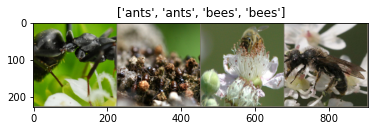

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

FINE TUNING

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\surya/.cache\torch\checkpoints\resnet18-5c106cde.pth


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6046 Acc: 0.6967
val Loss: 0.3198 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5218 Acc: 0.7951
val Loss: 0.2939 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.5158 Acc: 0.7828
val Loss: 0.3530 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.5523 Acc: 0.7992
val Loss: 0.2151 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4646 Acc: 0.8320
val Loss: 1.7707 Acc: 0.6601

Epoch 5/24
----------
train Loss: 0.8326 Acc: 0.7377
val Loss: 0.4972 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.4698 Acc: 0.7992
val Loss: 0.3196 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4219 Acc: 0.8238
val Loss: 0.2669 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3026 Acc: 0.8730
val Loss: 0.2510 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.2707 Acc: 0.8852
val Loss: 0.2578 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3451 Acc: 0.8770
val Loss: 0.2555 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3233 Acc: 0.8402
val Loss: 0.2506 Acc: 0.9216

Ep

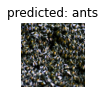

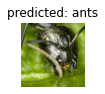

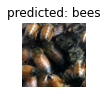

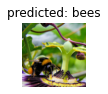

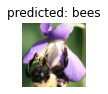

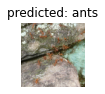

In [9]:
visualize_model(model_ft)

Feature Extractor

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5735 Acc: 0.6967
val Loss: 0.3927 Acc: 0.7908

Epoch 1/24
----------
train Loss: 0.4469 Acc: 0.7951
val Loss: 0.1961 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5528 Acc: 0.7541
val Loss: 0.3276 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.4116 Acc: 0.8156
val Loss: 0.1823 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4694 Acc: 0.8320
val Loss: 0.1798 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4044 Acc: 0.8361
val Loss: 0.1779 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3368 Acc: 0.8402
val Loss: 0.2354 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3362 Acc: 0.8770
val Loss: 0.1881 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3201 Acc: 0.8770
val Loss: 0.2012 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3465 Acc: 0.8402
val Loss: 0.1666 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2915 Acc: 0.8770
val Loss: 0.1766 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3447 Acc: 0.8197
val Loss: 0.1851 Acc: 0.9542

Ep

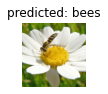

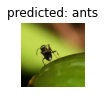

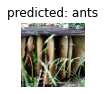

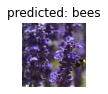

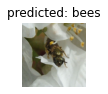

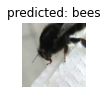

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [14]:
model_conv = torchvision.models.googlenet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\surya/.cache\torch\checkpoints\googlenet-1378be20.pth


In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6620 Acc: 0.5820
val Loss: 0.4826 Acc: 0.7647

Epoch 1/24
----------
train Loss: 0.4568 Acc: 0.7869
val Loss: 0.3155 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.5168 Acc: 0.7254
val Loss: 0.2667 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3885 Acc: 0.8156
val Loss: 0.3049 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4279 Acc: 0.8033
val Loss: 0.2266 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3461 Acc: 0.8566
val Loss: 0.2367 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3635 Acc: 0.8238
val Loss: 0.1988 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3766 Acc: 0.8689
val Loss: 0.2017 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3114 Acc: 0.8607
val Loss: 0.2103 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3710 Acc: 0.8238
val Loss: 0.2092 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.4616 Acc: 0.7787
val Loss: 0.2061 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3377 Acc: 0.8648
val Loss: 0.2202 Acc: 0.9412

Ep